# Evaluating multiple classification models in Python
### This analysis involves trying out and further tuning multiple classification models to build one that most accurately classifies the quality of an apple based on its characteristics.

## Data preparation
Importing CSV file and minimal preparation - there was only one row with missing values and one numeric column set as character type.

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import RocCurveDisplay as RCD, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [88]:
data = pd.read_csv('apple_quality.csv')

non_missing_rows = ~data.isnull().any(axis=1)
data = data[missing_vals_filter]
data['Acidity'] = data['Acidity'].astype('float64')
data.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good


## Getting familiar with data
Checking if outcome category counts are balanced and displaying summary of all the numerical variables. I created heatmap, presenting correlation matrix between all the predictors to spot if there are any cases of multicollinearity before training the models. Since there was none - and from characteristics of data, it did not seem to contain any outliers (checked with boxplots) - all of the variables were included. Also, already setting predictors and response variable in process.

In [228]:
X = data.drop(['A_id','Quality'], axis=1)
y = data['Quality']

print(f'\nIndependent variable counts:\n\
"Good" quality: {y.value_counts()[0]}\n\
"Bad" quality: {y.value_counts()[1]}\n\n\
Since classes are balanced, stratified cross-validation is not needed, \
normal K-Fold cross-validation will suffice.')
X.describe()


Independent variable counts:
"Good" quality: 2004
"Bad" quality: 1996

Since classes are balanced, stratified cross-validation is not needed, normal K-Fold cross-validation will suffice.


,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,0.076877
std,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,2.110270
min,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538
25%,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424
50%,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609
75%,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493
max,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736


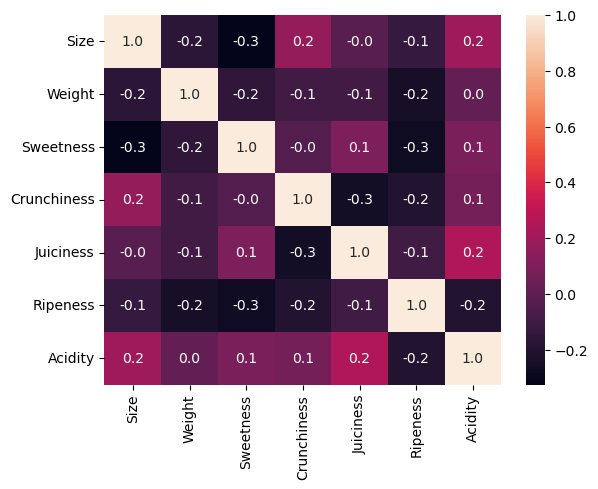

In [90]:
sns.heatmap(X.corr(), annot=True, fmt='.1f')
plt.show()

## Initial comparison of 4 standard classification models
After splitting data into train and test sets, I compared multiple models with default settings to select the most promising ones for further tuning. Based on their accuracy results from 10-fold cross-validation, and sensitivity/specificity ratios for different classification probability thresholds visualized with the use of ROC-AUC, the most promising models were KNN ans Random Forest.

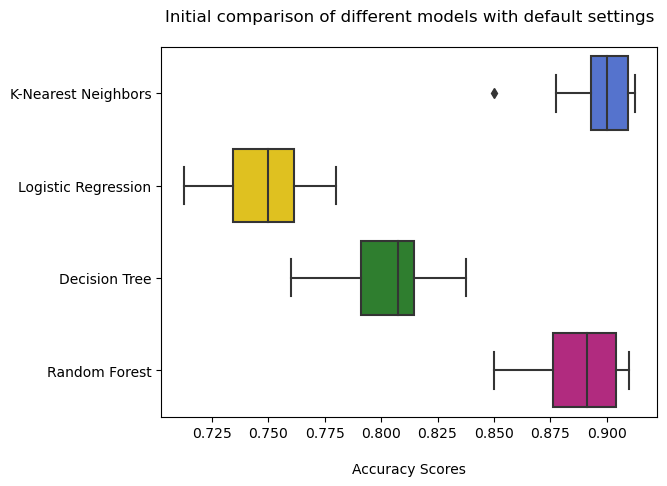

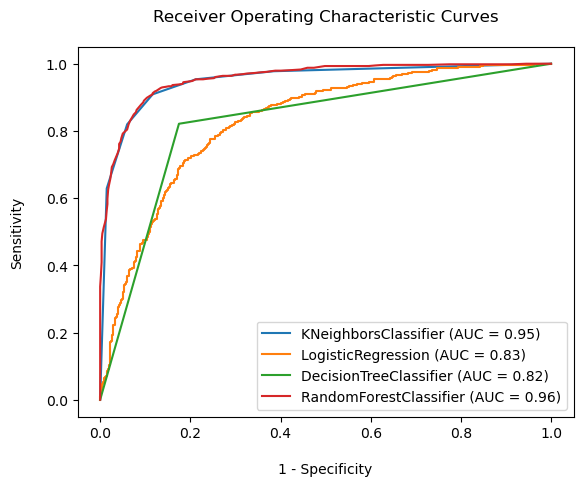

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

models = {
    'K-Nearest Neighbors':KNeighborsClassifier(),
    'Logistic Regression':LogisticRegression(),
    'Decision Tree':DecisionTreeClassifier(),
    'Random Forest':RandomForestClassifier()
}
accuracies = []

# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: #

scores_to_plt = {}
for key, model in models.items():
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    results = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    accuracies.append(results)
    scores_to_plt[key] = results

scores_to_plt = pd.DataFrame(scores_to_plt)
sns.boxplot(data=scores_to_plt, orient='h',
            palette={'K-Nearest Neighbors':'royalblue','Logistic Regression':'gold',
                    'Decision Tree':'forestgreen','Random Forest':'mediumvioletred'})\
.set(xlabel='\nAccuracy Scores', title='Initial comparison of different models with default settings\n')
plt.show()

# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: #

ax = plt.gca()

for model in models.values():
    model.fit(X_train, y_train)
    roc_auc_plt = RCD.from_estimator(model, X_test, y_test, ax=ax)

ax.set(xlabel='\n1 - Specificity', ylabel='Sensitivity\n', title='Receiver Operating Characteristic Curves\n')
plt.show()

## Tuning chosen models
Trying out sets of hyperparameters for selected models to find the ones with the best bias-variance trade-off. In case of Random Forest model, I used randomized search for hyperparameters to facilitate model creation. At the end, I visualized the results of both final models in form of accuracy-matrices.

In [140]:
param_grid_KNN = {'n_neighbors':np.arange(1,15)}
param_grid_RFC = {
    'n_estimators':np.arange(25,450,25),
    'criterion':['gini','entropy'],
    'max_depth':[2,3,4,5,6,7,8,9,10,None],
    'max_features':['sqrt',None]
}

KNN_CV = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_KNN,
    cv=KFold(10))

RFC_CV = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid_RFC,
    cv=KFold(10))

KNN_CV.fit(X_train, y_train)
RFC_CV.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'max_features': ['sqrt', None],
                                        'n_estimators': array([ 25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325,
       350, 375, 400, 425])})


The best classification model turned out to be 11-Nearest Neighbor model, accurately predicting 89.9% of cases.



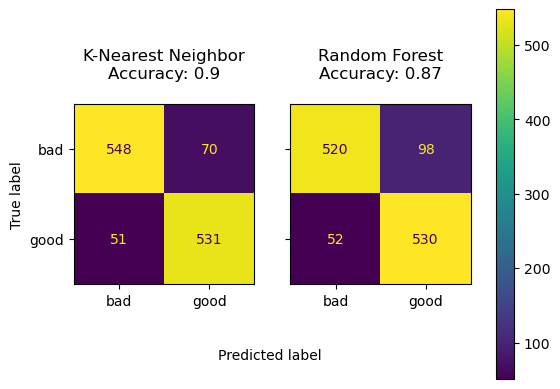

In [226]:
KNN_predictions = KNN_CV.predict(X_test)
RFC_predictions = RFC_CV.predict(X_test)

KNN_cm = confusion_matrix(y_test, KNN_predictions, labels=KNN_CV.classes_)
RFC_cm = confusion_matrix(y_test, RFC_predictions)

KNN_cm_disp = ConfusionMatrixDisplay(KNN_cm, display_labels=KNN_CV.classes_)
RFC_cm_disp = ConfusionMatrixDisplay(RFC_cm, display_labels=RFC_CV.classes_)

fig, axes = plt.subplots(1, 2, sharey='row')
KNN_cm_disp.plot(ax=axes[0])
RFC_cm_disp.plot(ax=axes[1])

KNN_cm_disp.ax_.set_title(f'K-Nearest Neighbor\nAccuracy: {round(KNN_CV.best_score_,2)}\n')
KNN_cm_disp.ax_.set_xlabel('')
KNN_cm_disp.im_.colorbar.remove()

RFC_cm_disp.ax_.set_title(f'Random Forest\nAccuracy: {round(RFC_CV.best_score_,2)}\n')
RFC_cm_disp.ax_.set_xlabel('')
RFC_cm_disp.ax_.set_ylabel('')
RFC_cm_disp.im_.colorbar.remove()

fig.colorbar(KNN_cm_disp.im_, ax=axes)
fig.text(0.35,0.15,'Predicted label')

neighbors = KNN_CV.best_params_['n_neighbors']
print(f'\nThe best classification model turned out to be {neighbors}-Nearest Neighbor model, \
accurately predicting {round((548+531)/(548+531+51+70)*100,1)}% of cases.\n')